# Odor bout rate and return point histogram Sleep paper

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stats
import scipy.stats as ss
from pylab import *
from scipy.optimize import curve_fit
from os.path import dirname, join as pjoin
import scipy.io as sio
from scipy.stats import gaussian_kde
from scipy.stats import sem 
from scipy.stats import ranksums

## Normalized bout histogram to plot return point

Data frame from Matlab

0. bout rate
1. fish number
2. bin number
3. preBout X position
4. preBout time in s


In [71]:
# change directory
bout_rates_ctrl=pd.read_csv(r"D:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rates_control.csv", header=None)
print(bout_rates_ctrl)

              0   1   2        3         4
0      3.906250   3   2  352.478   169.803
1      2.873563   3   2  351.041   170.559
2      0.062846   3   2  350.940   171.341
3      3.759398   3   2  351.000   265.523
4      4.115226   3   2  352.147   266.421
...         ...  ..  ..      ...       ...
11563  0.453309  20  46  887.976   481.032
11564  1.550388  20  46  889.613   557.018
11565  0.424628  20  46  888.800   746.910
11566  0.236798  21  46  888.795   234.425
11567  0.202634  21  46  887.698  1138.336

[11568 rows x 5 columns]


In [72]:
# change directory
bout_rates_SD=pd.read_csv(r"D:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rates_SD.csv", header=None)
print(bout_rates_SD)

               0   1   2        3         4
0       0.174642   6   1  340.409   333.003
1       3.300330   6   1  340.409   339.049
2       2.617801   6   1  341.250   552.279
3       2.525253   5   2  354.523   227.667
4       1.128668   6   2  354.474   941.022
...          ...  ..  ..      ...       ...
17248  10.989011  10  46  888.714  1133.423
17249   1.610306  10  46  888.714  1133.846
17250   4.237288  10  46  888.714  1134.939
17251   0.261643  10  46  888.714  1135.477
17252   3.012048  10  46  888.714  1139.606

[17253 rows x 5 columns]


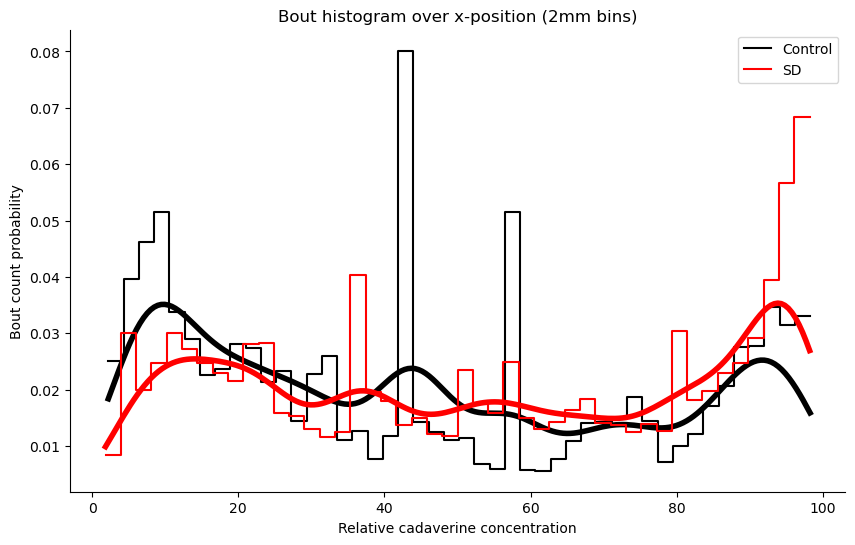

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming data1 and data2 are pandas DataFrames
data1 = bout_rates_ctrl
data2 = bout_rates_SD

#convert x values to relative values for cadaverine concentration
preBout_1 = data1[3]
preBout_2=data2[3]
x_min = 330
x_max = 900
normalized_preBout_1 = (preBout_1 - x_min) / (x_max - x_min) * 100
normalized_preBout_2 = (preBout_2 - x_min) / (x_max - x_min) * 100;

# Create a figure
plt.figure(figsize=(10, 6))

# Plot both histograms using histplot ; previously bins: 85, 46 bins ~2mm per bin (550 pixels total lane length)
sns.histplot(data=data1, x=normalized_preBout_1, kde=True, bins=46,  color='black',element="step", fill=False, 
             label='Control',stat='probability',
            line_kws = dict(linewidth = 4))
sns.histplot(data=data2, x=normalized_preBout_2, kde=True, bins=46, color='red',element="step", fill=False,
             label='SD',stat='probability',
              line_kws = dict(linewidth = 4))

# Add labels and title
plt.ylabel("Bout count probability")
plt.xlabel("Relative cadaverine concentration")
plt.title("Bout histogram over x-position (2mm bins)")

#plt.ylim(0.0, 0.06)
# Add a legend to distinguish the two distributions
plt.legend()

# Remove the top and right spines for a cleaner look
sns.despine(right=True, bottom=False)

# Save or display the plot
#plt.savefig(r"E:\Olfaction\Preference_index_starved\complete_starvation\Pref_index_starvation_3h\return_point.pdf")
plt.show()


## Bout rates

## New trials!!

bout rate difference calculated by substracting the bout rate 2cm close to odor source from the bout rate far away from odor source.

In [ ]:
test new bout rate 

1. Time between bouts is calculated. 2. Bins 2.6cm on the left and on the right are created. 3. Calcualtion of total bouts per fish left and right. 
4. Calculation of the time each fish spends on the left and the right. 5. Bout rate is calculated for each fish. 6. The eman over all fish is determined.

## Control group

In [74]:
# Assuming you already loaded the dataframe with appropriate column names:
bout_rates_ctrl.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time']
#print('first',bout_rates_ctrl)

# calculate bout duration
bout_duration_ctrl = bout_rates_ctrl.sort_values(['fish_number', 'prebout_time']).copy()
bout_duration_ctrl['time_to_next_bout'] = bout_duration_ctrl.groupby('fish_number')['prebout_time'].shift(-1) - bout_duration_ctrl['prebout_time']
#remove the last bout per fish (since it has NaN as there's no next bout)
bout_duration_ctrl = bout_duration_ctrl.dropna(subset=['time_to_next_bout'])
#print(bout_duration_ctrl)

# Create left and right bin subsets
# each bin ~2mm
left_df_ctrl = bout_duration_ctrl[bout_duration_ctrl['bin_number'].between(1, 13)] #bins 1-13 = 2.6cm on the left (1/4 of the lane on the left)
right_df_ctrl = bout_duration_ctrl[bout_duration_ctrl['bin_number'].between(33, 46)] # bins 33-46= 2.6cm on the right (1/4 of the lane on the right)
#print(right_df_ctrl)

# Count total bouts per fish (each row is a bout)
left_bout_counts_ctrl = left_df_ctrl.groupby('fish_number').size().rename("total_bouts")
#print(left_bout_counts_ctrl)
right_bout_counts_ctrl = right_df_ctrl.groupby('fish_number').size().rename("total_bouts")
#print(right_bout_counts_ctrl)

# Total time spent per fish
left_time_ctrl = left_df_ctrl.groupby('fish_number')['time_to_next_bout'].sum().rename("total_time_left")
right_time_ctrl = right_df_ctrl.groupby('fish_number')['time_to_next_bout'].sum().rename("total_time_right")
print('left_time_ctrl',left_time_ctrl)

# Combine into left and right summary tables
left_summary_ctrl = left_bout_counts_ctrl.to_frame().join(left_time_ctrl)
right_summary_ctrl = right_bout_counts_ctrl.to_frame().join(right_time_ctrl)
print('left_summary',left_summary_ctrl)

#calculate bout rate
left_summary_ctrl["bout_rate_left_per_sec"] = left_summary_ctrl["total_bouts"] / left_summary_ctrl["total_time_left"]
left_summary_ctrl["bout_rate_left_per_min"] = left_summary_ctrl["bout_rate_left_per_sec"] * 60
#print('left_summary',left_summary_ctrl)

right_summary_ctrl["bout_rate_right_per_sec"] = right_summary_ctrl["total_bouts"] / right_summary_ctrl["total_time_right"]
right_summary_ctrl["bout_rate_right_per_min"] = right_summary_ctrl["bout_rate_right_per_sec"] * 60
print('right_summary',right_summary_ctrl)

# calculate the means
mean_left_bout_rate_ctrl = left_summary_ctrl["bout_rate_left_per_min"].mean()
SEM_left_bout_rate_ctrl = sem(left_summary_ctrl["bout_rate_left_per_min"])

mean_right_bout_rate_ctrl = right_summary_ctrl["bout_rate_right_per_min"].mean()
SEM_right_bout_rate_ctrl = sem(right_summary_ctrl["bout_rate_right_per_min"])

# Output results
print("Left side mean bout rate:")
print(f" {mean_left_bout_rate_ctrl:.2f} bouts/min +/- {SEM_left_bout_rate_ctrl:.4f}")

print("\nRight side mean bout rate:")
print(f" {mean_right_bout_rate_ctrl:.2f} bouts/min +/- {SEM_right_bout_rate_ctrl:.4f}")


left_time_ctrl fish_number
3      762.720
4     1136.104
5      450.523
6      180.810
7      735.823
8      840.946
10    1169.908
11     709.897
12     293.295
13    1070.652
15      61.813
16      36.632
17    1377.186
18     865.406
19    1028.307
21     292.210
Name: total_time_left, dtype: float64
left_summary              total_bouts  total_time_left
fish_number                              
3                    358          762.720
4                    218         1136.104
5                    202          450.523
6                     61          180.810
7                    283          735.823
8                    177          840.946
10                    89         1169.908
11                   371          709.897
12                   102          293.295
13                  1261         1070.652
15                    22           61.813
16                     5           36.632
17                   827         1377.186
18                   112          865.406
19        

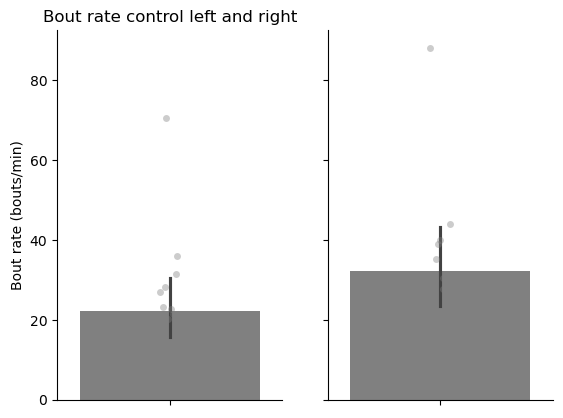

In [75]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_summary_ctrl['bout_rate_left_per_min'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax1,y="bout_rate_left_per_min", data=left_summary_ctrl, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_summary_ctrl['bout_rate_right_per_min'], color = "grey", orient="v")
ax = sns.stripplot(ax=ax2,y="bout_rate_right_per_min", data=right_summary_ctrl, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate control left and right")
#ax.set_ylim(0, 35)
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
fig.savefig(r"D:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rate_left_right_control.pdf")

In [76]:
# stats left vs right bout rate
p=ranksums(left_summary_ctrl['bout_rate_left_per_min'], right_summary_ctrl['bout_rate_right_per_min'])
print(f"left vs right: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}")

left vs right: statistic=-1.929528, p-value=0.0536653918


#### Bout rate difference

bout rate difference= bout rate right (high odor) - bout rate left (low odor)

In [77]:
# Merge left and right bout rates for each fish
bout_rate_df_ctrl = pd.merge(left_summary_ctrl, right_summary_ctrl, on='fish_number')
print(bout_rate_df_ctrl)

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_ctrl['bout_rate_difference'] = right_summary_ctrl['bout_rate_right_per_min'] - left_summary_ctrl['bout_rate_left_per_min']
print(bout_rate_df_ctrl)

# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_ctrl = bout_rate_df_ctrl['bout_rate_difference'].mean()
sem_bout_rate_difference_ctrl = sem(bout_rate_df_ctrl['bout_rate_difference'])

# print results
#print("Mean bout rate difference Control")
print(f" {mean_bout_rate_difference_ctrl:.4f} bouts/min +/- {sem_bout_rate_difference_ctrl:.4f}")

             total_bouts_x  total_time_left  bout_rate_left_per_sec  \
fish_number                                                           
3                      358          762.720                0.469373   
5                      202          450.523                0.448368   
6                       61          180.810                0.337371   
7                      283          735.823                0.384603   
8                      177          840.946                0.210477   
11                     371          709.897                0.522611   
15                      22           61.813                0.355912   
16                       5           36.632                0.136493   
17                     827         1377.186                0.600500   
21                     110          292.210                0.376442   

             bout_rate_left_per_min  total_bouts_y  total_time_right  \
fish_number                                                            
3  

## treatment group

In [78]:
# Assuming you already loaded the dataframe with appropriate column names:
bout_rates_SD.columns = ['bout_rate', 'fish_number', 'bin_number', 'prebout_Xposition', 'prebout_time']
#print('first',bout_rates_ctrl)

# calculate bout duration
bout_duration_SD = bout_rates_SD.sort_values(['fish_number', 'prebout_time']).copy()
bout_duration_SD['time_to_next_bout'] = bout_duration_SD.groupby('fish_number')['prebout_time'].shift(-1) - bout_duration_SD['prebout_time']
#remove the last bout per fish (since it has NaN as there's no next bout)
bout_duration_SD= bout_duration_SD.dropna(subset=['time_to_next_bout'])
#print(bout_duration_ctrl)

# Create left and right bin subsets
# each bin ~2mm
left_df_SD = bout_duration_SD[bout_duration_SD['bin_number'].between(1, 13)] #bins 1-13 = 2.6cm on the left (1/4 of the lane on the left)
right_df_SD= bout_duration_SD[bout_duration_SD['bin_number'].between(33, 46)] # bins 33-46= 2.6cm on the right (1/4 of the lane on the right)
#print(right_df_ctrl)

# Count total bouts per fish (each row is a bout)
left_bout_counts_SD = left_df_SD.groupby('fish_number').size().rename("total_bouts")
#print(left_bout_counts_ctrl)
right_bout_counts_SD = right_df_SD.groupby('fish_number').size().rename("total_bouts")
#print(right_bout_counts_ctrl)

# Total time spent per fish
left_time_SD = left_df_SD.groupby('fish_number')['time_to_next_bout'].sum().rename("total_time_left")
right_time_SD = right_df_SD.groupby('fish_number')['time_to_next_bout'].sum().rename("total_time_right")
print('left_time_ctrl',left_time_SD)

# Combine into left and right summary tables
left_summary_SD = left_bout_counts_SD.to_frame().join(left_time_SD)
right_summary_SD = right_bout_counts_SD.to_frame().join(right_time_SD)
print('left_summary',left_summary_SD)

#calculate bout rate
left_summary_SD["bout_rate_left_per_sec"] = left_summary_SD["total_bouts"] / left_summary_SD["total_time_left"]
left_summary_SD["bout_rate_left_per_min"] = left_summary_SD["bout_rate_left_per_sec"] * 60
#print('left_summary',left_summary_SD)

right_summary_SD["bout_rate_right_per_sec"] = right_summary_SD["total_bouts"] / right_summary_SD["total_time_right"]
right_summary_SD["bout_rate_right_per_min"] = right_summary_SD["bout_rate_right_per_sec"] * 60
print('right_summary',right_summary_SD)

# calculate the means
mean_left_bout_rate_SD = left_summary_SD["bout_rate_left_per_min"].mean()
SEM_left_bout_rate_SD = sem(left_summary_SD["bout_rate_left_per_min"])

mean_right_bout_rate_SD = right_summary_SD["bout_rate_right_per_min"].mean()
SEM_right_bout_rate_SD = sem(right_summary_SD["bout_rate_right_per_min"])

# Output results
print("Left side mean bout rate:")
print(f" {mean_left_bout_rate_SD:.2f} bouts/min +/- {SEM_left_bout_rate_SD:.4f}")

print("\nRight side mean bout rate:")
print(f" {mean_right_bout_rate_SD:.2f} bouts/min +/- {SEM_right_bout_rate_SD:.4f}")


left_time_ctrl fish_number
4      519.604
5      470.813
6     1421.752
7      726.481
8      769.445
10     133.403
11    1150.039
13    1316.277
14    1279.181
15     654.942
16     593.330
17     787.414
18    1288.780
19     139.492
21     162.082
22      19.908
23     436.655
25      11.046
Name: total_time_left, dtype: float64
left_summary              total_bouts  total_time_left
fish_number                              
4                    187          519.604
5                    268          470.813
6                    455         1421.752
7                    444          726.481
8                    439          769.445
10                    28          133.403
11                   198         1150.039
13                   270         1316.277
14                   490         1279.181
15                   517          654.942
16                   767          593.330
17                   126          787.414
18                   554         1288.780
19                    

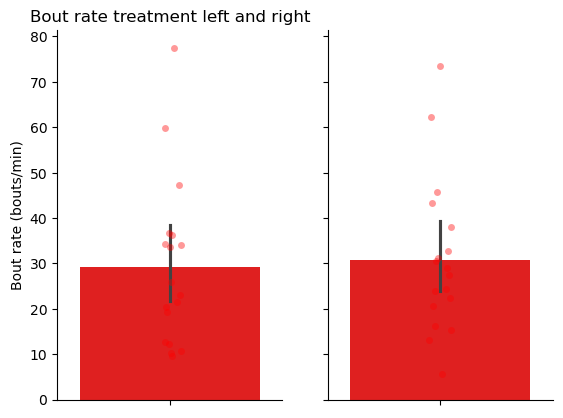

In [79]:
#a4_dims = (11.7, 8.27)
#fig, ax = plt.subplots(figsize=a4_dims)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax = sns.barplot(ax=ax1,y=left_summary_SD['bout_rate_left_per_min'], color = "red", orient="v")
ax = sns.stripplot(ax=ax1,y="bout_rate_left_per_min", data=left_summary_SD, dodge=True, color="red", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=right_summary_SD['bout_rate_right_per_min'], color = "red", orient="v")
ax = sns.stripplot(ax=ax2,y="bout_rate_right_per_min", data=right_summary_SD, dodge=True, color="red", alpha = 0.4,jitter = 0.05)

ax1.set_title("Bout rate treatment left and right")
#ax.set_ylim(0, 35)
ax1.set_ylabel("Bout rate (bouts/min)")
sns.despine(right=True, bottom=False)
fig.savefig(r"D:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rate_left_right_control.pdf")

In [80]:
# stats left vs right bout rate
p=ranksums(left_summary_SD['bout_rate_left_per_min'], right_summary_SD['bout_rate_right_per_min'])
print(f"left vs right: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}")

left vs right: statistic=-0.474579, p-value=0.6350870788


In [81]:
# stats control vs treatment left and control vs treatment right
p=ranksums(left_summary_ctrl['bout_rate_left_per_min'], left_summary_SD['bout_rate_left_per_min'])
print(f"control vs treatment low odor: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}") #left

p=ranksums(right_summary_ctrl['bout_rate_right_per_min'], right_summary_SD['bout_rate_right_per_min'])
print(f"control vs treatment high odor: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}") #right

control vs treatment low odor: statistic=-1.311125, p-value=0.1898156835
control vs treatment high odor: statistic=0.120096, p-value=0.9044070096


In [82]:
print(f"control left n={len(left_summary_ctrl)}, control right n={len(right_summary_ctrl)},treatment left n={len(left_summary_SD)}, treatment right n={len(right_summary_SD)}")

control left n=16, control right n=13,treatment left n=18, treatment right n=18


### Bout rate difference

In [83]:
# Merge left and right bout rates for each fish
bout_rate_df_SD = pd.merge(left_summary_SD, right_summary_SD, on='fish_number')
#print(bout_rate_df_SD)

# Calculate the difference: bout rate right - bout rate left
bout_rate_df_SD['bout_rate_difference'] = right_summary_SD['bout_rate_right_per_min'] - left_summary_SD['bout_rate_left_per_min']
#print(bout_rate_df_SD)

# Calculate the mean bout rate difference across all fish
mean_bout_rate_difference_SD = bout_rate_df_SD['bout_rate_difference'].mean()
sem_bout_rate_difference_SD = sem(bout_rate_df_SD['bout_rate_difference'])

# print results
#print("Mean bout rate difference Control")
print(f" {mean_bout_rate_difference_SD:.4f} bouts/min +/- {sem_bout_rate_difference_SD:.4f}")

 2.8359 bouts/min +/- 3.2710


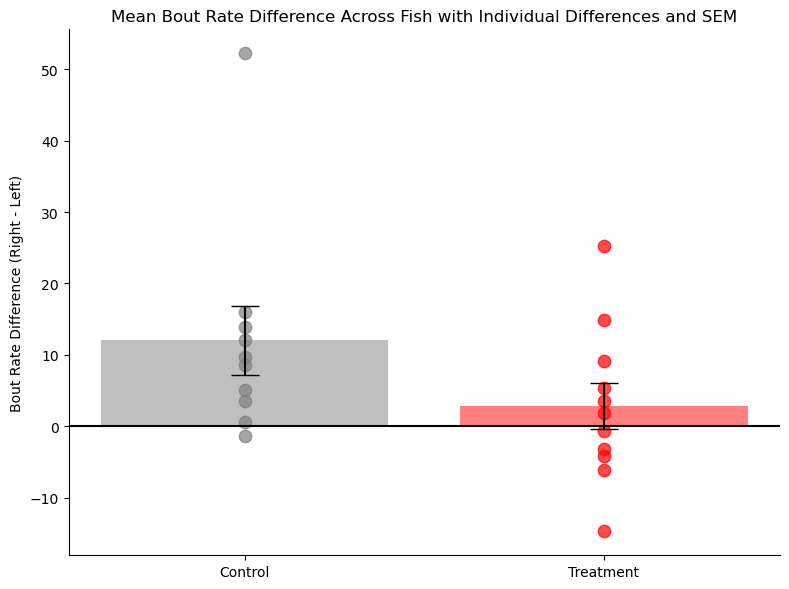

In [84]:
# Set up figure
fig, ax = plt.subplots(figsize=(8, 6))

# X-axis positions
x = np.arange(2)
x_labels = ['Control', 'Treatment']

# Y values and errors
means = [mean_bout_rate_difference_ctrl, mean_bout_rate_difference_SD]
errors = [sem_bout_rate_difference_ctrl, sem_bout_rate_difference_SD]
colors = ['grey', 'red']

# Bar plot with error bars
bars = ax.bar(x, means, yerr=errors, color=colors, alpha=0.5, capsize=10)

# Scatter individual values
ax.scatter(
    [x[0]] * len(bout_rate_df_ctrl), bout_rate_df_ctrl['bout_rate_difference'],
    color='grey', s=80, alpha=0.7
)
ax.scatter(
    [x[1]] * len(bout_rate_df_SD), bout_rate_df_SD['bout_rate_difference'],
    color='red', s=80, alpha=0.7
)

# Axis formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Bout Rate Difference (Right - Left)")
ax.set_title("Mean Bout Rate Difference Across Fish with Individual Differences and SEM")
ax.axhline(0, color='black', linestyle='-')

sns.despine()
plt.tight_layout()
plt.show()

fig.savefig(r"D:\Olfaction\Prefernece_index_cadaverine\0mM_cad_control\bout_rate_difference.pdf")

In [85]:
p=ranksums(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'])
print(f"control vs treatment: statistic={p.statistic:.6f}, p-value={p.pvalue:.10f}")

control vs treatment: statistic=1.619611, p-value=0.1053158184


In [86]:
p=ss.ttest_ind(bout_rate_df_ctrl['bout_rate_difference'], bout_rate_df_SD['bout_rate_difference'])
print(p)

TtestResult(statistic=1.6116589099429472, pvalue=0.12352367415829044, df=19.0)


In [87]:
print(f"control n={len(bout_rate_df_ctrl)},treatment n={len(bout_rate_df_SD)}")

control n=10,treatment n=11


### test how many fish are the same between left and right bins and control and treatment

In [90]:
print(left_summary_ctrl.index)
print(right_summary_ctrl.index)

Index([3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21], dtype='int64', name='fish_number')
Index([1, 2, 3, 5, 6, 7, 8, 11, 15, 16, 17, 20, 21], dtype='int64', name='fish_number')


In [91]:
print(left_summary_SD.index)
print(right_summary_SD.index)

Index([4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 25], dtype='int64', name='fish_number')
Index([1, 2, 3, 5, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 20, 22, 23, 24], dtype='int64', name='fish_number')


In [92]:
# Find common fish numbers within control
common_fish = left_summary_ctrl.index.intersection(right_summary_ctrl.index)
print("Common fish numbers within control:", sorted(common_fish))
print(len(common_fish))

# within treatment
common_fish = left_summary_SD.index.intersection(right_summary_SD.index)
print("Common fish numbers within treatment:", sorted(common_fish))
print(len(common_fish))


Common fish numbers within control: [3, 5, 6, 7, 8, 11, 15, 16, 17, 21]
10
Common fish numbers within treatment: [5, 7, 8, 10, 14, 15, 16, 17, 19, 22, 23]
11


test end